<a href="https://colab.research.google.com/github/Neuralwood-Net/face-recognizer-9000/blob/main/notebooks/pretraining_celeba_cnn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train images of authors, 64x64px
## Ok network

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


### Imports

In [5]:
import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

from google.cloud import storage

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Read and prepare the data

In [5]:
from google.cloud import storage


client = storage.Client()

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

zipfilename = "/home/jupyter/data/faces/balanced_sampled_128px_color_130480_images_33_percent_val.zip"
blob_name = "faces/balanced_sampled_128px_color_130480_images_33_percent_val.zip"
blob = bucket.get_blob(blob_name)

blob.download_to_filename(zipfilename)

In [20]:
! rm -rf /home/jupyter/data/faces/images/val/.ipynb_checkpoints

In [ ]:
!unzip /home/jupyter/data/faces/images_final_balanced_128px_color_26180_train_ca_300_val_per_class.zip -d /home/jupyter/data/faces/

In [10]:
BATCH_SIZE = 16

data_transforms = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(128),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # transforms.Normalize([0.5], [0.5]),
])

data_dir = '/home/jupyter/data/faces/images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names


['Kjartan', 'Lars', 'Morgan', 'Other']

In [8]:
image_datasets['val'].classes
dataset_sizes

{'train': 104721, 'val': 31444}

torch.Size([16, 1, 128, 128])


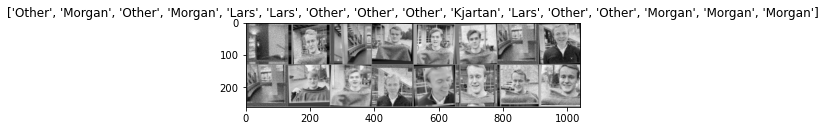

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Create functions for training, validation, and evaluation

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    num_img = {
        "train": 0,
        "val": 0,
    }
    
    datapoints_per_epoch = 100
    
    imgs_per_datapoint = {
        "train": int(float(dataset_sizes["train"] / datapoints_per_epoch)),
        "val": int(float(dataset_sizes["val"] / datapoints_per_epoch)),
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        with open(f"/home/jupyter/logs/training/{type(model).__name__}-{since}.csv", "a") as f:

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                plot_loss = 0
                plot_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=f"Epoch: {epoch} ({phase})"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    plot_loss += loss.item() * inputs.size(0)
                    plot_corrects += torch.sum(preds == labels.data)
                    
                    num_img[phase] += BATCH_SIZE
                    
                    if num_img[phase] % imgs_per_datapoint[phase] == 0:
                        f.write(f"{time.time()},{epoch},{phase},\
                        {num_img[phase]},{plot_loss / float(imgs_per_datapoint[phase])},\
                        {plot_corrects / float(imgs_per_datapoint[phase])}\n")
                        
                        plot_loss = 0
                        plot_corrects = 0
                        
                        
                """
                if phase == 'train':
                    scheduler.step()
                """

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(
                        {
                            "loss": epoch_loss,
                            "acc": epoch_acc,
                            "epoch": epoch,
                            "parameters": best_model_wts,
                        },
                        f"/home/jupyter/checkpoints/{type(model).__name__}-{since}.data",
                    )
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Prepare and train the CNN

In [10]:
class CNN(nn.Module):
    size_after_conv = 4 * 4 * 512
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(   
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            #nn.Dropout(),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            #nn.Dropout(),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.classify = nn.Sequential(
            nn.Linear(self.size_after_conv, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, len(class_names)),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.size_after_conv)
        x = self.classify(x)

        return x

cnn = CNN().to(device)
print(cnn)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): ReLU()
 

In [19]:
from collections import Counter
c = Counter()
for inputs, labels in dataloaders["train"]:
    c.update(list(labels.numpy()))
    
c

Counter({2: 26180, 1: 26180, 0: 26181, 3: 26180})

In [87]:
class CNNSmall(nn.Module):
    def __init__(self):
        super(CNNSmall, self).__init__()
        self.fc1 = nn.Linear(128*128, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 4)
        
    def forward(self, x):
        x = x.view(-1, 128*128)
        x = F.relu(self.fc1(x))
        x = F.dropout(F.relu(self.fc2(x)), p=0.25)
        x = F.relu(self.fc3(x))

        return x
    
cnn2 = CNNSmall().to(device)
cnn2

CNNSmall(
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=4, bias=True)
)

In [76]:
class CNNSlightlyLarger(nn.Module):
    size_after_conv = 4 * 4 * 32
    def __init__(self):
        super(CNNSlightlyLarger, self).__init__()
        self.features = nn.Sequential(   
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.classify = nn.Sequential(
            nn.Linear(self.size_after_conv, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(class_names)),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.size_after_conv)
        x = self.classify(x)

        return x
    
cnn3 = CNNSlightlyLarger().to(device)

In [61]:
tensor_list = list(cnn2.state_dict().items())
for layer_tensor_name, tensor in tensor_list:
    print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    
print()
tensor_list = list(cnn.state_dict().items())
for layer_tensor_name, tensor in tensor_list:
    print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))

Layer fc1.weight: 16777216 elements
Layer fc1.bias: 1024 elements
Layer fc2.weight: 524288 elements
Layer fc2.bias: 512 elements
Layer fc3.weight: 2048 elements
Layer fc3.bias: 4 elements

Layer features.0.weight: 1152 elements
Layer features.0.bias: 128 elements
Layer features.3.weight: 294912 elements
Layer features.3.bias: 256 elements
Layer features.6.weight: 1179648 elements
Layer features.6.bias: 512 elements
Layer features.10.weight: 2359296 elements
Layer features.10.bias: 512 elements
Layer features.14.weight: 2359296 elements
Layer features.14.bias: 512 elements
Layer classify.0.weight: 16777216 elements
Layer classify.0.bias: 2048 elements
Layer classify.3.weight: 4194304 elements
Layer classify.3.bias: 2048 elements
Layer classify.6.weight: 8192 elements
Layer classify.6.bias: 4 elements


In [84]:
net = cnn2.cpu()
for idx, (inputs, labels) in enumerate(dataloaders["train"]):
    print(labels)
    # print(inputs)
    out = F.softmax(net(inputs), dim=1)
    
    print(out)
    if idx > 1:
        break

tensor([1, 1, 2, 2])
tensor([[2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01],
        [6.1696e-32, 1.0000e+00, 6.1696e-32, 6.1696e-32],
        [2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01],
        [2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01]],
       grad_fn=<SoftmaxBackward>)
tensor([3, 2, 0, 2])
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<SoftmaxBackward>)
tensor([1, 3, 2, 1])
tensor([[3.8705e-28, 1.0000e+00, 3.8705e-28, 3.8705e-28],
        [2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01],
        [2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01],
        [1.4013e-43, 1.0000e+00, 1.4013e-43, 1.4013e-43]],
       grad_fn=<SoftmaxBackward>)


In [13]:
squeezenet = models.squeezenet1_1(pretrained=True)
num_chn = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(num_chn, len(class_names), 1, 1)
squeezenet = squeezenet.to(device)

In [ ]:
optimizer = torch.optim.Adam(squeezenet.classifier[1].parameters())
loss_function = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(squeezenet, loss_function, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch: 0 (train):   0%|          | 0/6546 [00:00<?, ?it/s]

Epoch 0/24
----------


Epoch: 0 (val):   0%|          | 0/1966 [00:00<?, ?it/s]

train Loss: 0.1892 Acc: 0.9317


Epoch: 1 (train):   0%|          | 0/6546 [00:00<?, ?it/s]

val Loss: 2.0044 Acc: 0.4790

Epoch 1/24
----------


Epoch: 1 (train):  25%|██▍       | 1623/6546 [13:14<39:45,  2.06it/s]

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
images, labels = next(iter(test_loader))

for idx, (image, label) in enumerate(zip(images, labels)):
    pred = int(torch.argmax(cnn(image.view(-1, 1, 64, 64).to(device))))
    convert = {0: "Lars", 1: "Morgan", 2: "Kjartan", 3: "Ingen"}
    
    plt.imshow(image.view(64, 64).cpu(), cmap="gray")
    plt.text(2, 54, f"Image {idx + 1}", fontsize=14, color="white")
    plt.text(2, 58, f"Predicted: `{convert[pred]}`", fontsize=14, color="white")
    plt.text(2, 62, f"Actual   : `{convert[label.item()]}`", fontsize=14, color="white")
    plt.pause(0.05)

In [ ]:
import cv2

In [ ]:
cnn.eval()

class Label:
    def __init__(self, label):
        self.label = label
    
    def item(self):
        return self.label


filename = "/content/lars_5.png"
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (64, 64)) / 255.0
plt.imshow(image, cmap="gray")
convert = {0: "Lars", 1: "Morgan", 2: "Kjartan", 3: "Ingen"}

pred = int(torch.argmax(cnn(torch.Tensor(image).view(-1, 1, 64, 64).to(device))))
# plt.text(2, 58, f"Predicted: `{convert[pred]}`", fontsize=14, color="white")
# plt.text(2, 62, f"Actual   : `{convert[label.item()]}`", fontsize=14, color="white")

if "morgan" in filename:
    label = Label(1)
elif "lars" in filename:
    label = Label(0)
else:
    label = Label(3)

print(f"Predicted: `{convert[pred]}`" )
print(f"Actual   : `{convert[label.item()]}`")

# plt.imshow(image.view(64, 64).cpu().to_numpy(), cmap="gray")
